In [1]:
# Data processing
import iris
import iris.analysis
import iris.coord_categorisation
import warnings
warnings.filterwarnings('ignore', module='iris')
import numpy as np
from pathlib import Path
from scipy import stats
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3)
def custom_ctcklbls(x, pos):
    '''Custom format for colorbar tick labels'''
    return '{:1.1f}'.format(x)
plt.rcParams['mathtext.default'] = 'regular'

In [17]:
# Switches
base_exp = 'CHEM'
var = 'iprono2'
savefig = True
publish = True
# ch4 ppb
# c2h6 ppb

In [18]:
# Choose experiments
job_dict = {'BASE OLD':'xojnd',
            'BASE'    :'xojng',
            'CHEM'    :'xojnh',
            'MARI'    :'xojni',
            'FIRE'    :'xojnc',
            'FULL'    :'xojnl',
            'ORIG'    :'xolnb',
            'UPDT'    :'xolna'}
base_job = job_dict[base_exp]
# Choose variables
var_dict = {'molar_mass': {'o3':47.997, 'no':30.006, 'no2':46.006, 'hono':47.013, 'ho2no2':79.01224, 'hno3':63.012, 'n2o5':108.01, 'pan':121.0489, 'ppan':135.0755,
                           'meono2':77.0394, 'etono2':91.0660, 'nprono2':105.0926, 'iprono2':105.0926,
                           'ch4':16.0425, 'c2h6':30.0690},
            'str': {'o3':'$O_3$', 'no':'NO', 'no2':'$NO_2$', 'hono':'HONO', 'ho2no2':'$HO_2NO_2$', 'hno3':'$HNO_3$', 'n2o5':'N_2O_5', 'pan':'PAN', 'ppan':'PPN', 
                    'nox':'$NO_x$', 'noy':'$NO_y$', 'meono2':'$MeONO_2$', 'etono2':'$EtONO_2$', 'nprono2':'$nPrONO_2$', 'iprono2':'$iPrONO_2$',
                    'ch4':'$CH_4$', 'c2h6':'$C_2H_6$'}}
M_air = 28.97 # molar mass of dry air [g mol-1]
var_coeff = (M_air/var_dict['molar_mass'][var])*1e12
# Read data
path_to_ukca = Path.cwd().parent / 'data'
base = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_{var}.nc'), var)*var_coeff
# Remove the first 2 years as a spin up
base = base[24::,...]
# Add season and year coordinates
iris.coord_categorisation.add_season(base, 'time', name='season')
iris.coord_categorisation.add_season_year(base, 'time', name='year')
# Simplify dimensions
nlons = base.coord('longitude').shape[0]
nlats = base.coord('latitude').shape[0]
nlevs = base.coord('level_height')[0:23].shape[0]
lons = base.coord('longitude').points
lats = base.coord('latitude').points

In [19]:
# Path to figures
path_to_figs = Path.cwd().parent.parent.parent / 'results' / f'{base_job}' / var
path_to_figs.mkdir(exist_ok=True)
if publish:
    mpl.rcParams['xtick.labelsize'] = 12 # 25
    mpl.rcParams['ytick.labelsize'] = 12 # 25
    mpl.rcParams['axes.titlesize'] = 12 # 40
    mpl.rcParams['axes.labelsize'] = 12 # 30
    plt.rcParams['font.size'] = 12 # 30

#### Boundary layer seasonal means

In [20]:
# Extract time series of boundary layer (0-2 km) seasonal means
base_pbl_djf = (base.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
base_pbl_mam = (base.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
base_pbl_jja = (base.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
base_pbl_son = (base.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
# Calculate boundary layer seasonal means
base_pbl_djf_mean = base_pbl_djf.collapsed('year', iris.analysis.MEAN)
base_pbl_mam_mean = base_pbl_mam.collapsed('year', iris.analysis.MEAN)
base_pbl_jja_mean = base_pbl_jja.collapsed('year', iris.analysis.MEAN)
base_pbl_son_mean = base_pbl_son.collapsed('year', iris.analysis.MEAN)
# Add cyclic point for plotting on a global map
cyc_base_pbl_djf_mean, cyclic_lons = cartopy.util.add_cyclic_point(base_pbl_djf_mean.data, coord=base_pbl_djf_mean.coord('longitude').points)
cyc_base_pbl_mam_mean = cartopy.util.add_cyclic_point(base_pbl_mam_mean.data)
cyc_base_pbl_jja_mean = cartopy.util.add_cyclic_point(base_pbl_jja_mean.data)
cyc_base_pbl_son_mean = cartopy.util.add_cyclic_point(base_pbl_son_mean.data)
# Find max boundary layer seasonal mean
print(np.max(base_pbl_djf_mean.data))
print(np.max(base_pbl_mam_mean.data))
print(np.max(base_pbl_jja_mean.data))
print(np.max(base_pbl_son_mean.data))

28.194944
13.225853
17.393787
19.226295


- CHEM CH4: 2626.1548 2158.0188 2234.3745 2515.7778


- CHEM C2H6: 27.912663 15.5676365 12.250808 22.321259


- CHEM MeONO2: 18.90242 17.880545 21.308216 18.330566
- MARI MeONO2: 32.170128 30.77222 35.45551 32.71014
- FULL MeONO2: 38.524216 34.947975 41.333027 38.313625


- CHEM iPrONO2: 28.194944 13.225853 17.393787 19.226295
- MARI iPrONO2: 0.83687353 0.8266778 0.8976035 0.82841814
- FULL: iPrONO2: 28.33859 12.866397 17.083832 20.194317

In [23]:
# Boundary layer seasonal mean difference plotting parameters
if var == 'meono2':
    pbl_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='Purples', levels=np.arange(0,50,5))
elif var == 'iprono2':
    pbl_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='Purples')#, levels=np.arange(0,35,5))
elif var == 'ch4':
    pbl_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='Purples', levels=np.arange(1700,2700,50))
elif var == 'c2h6':
    pbl_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='Purples', levels=np.arange(0,35,5))

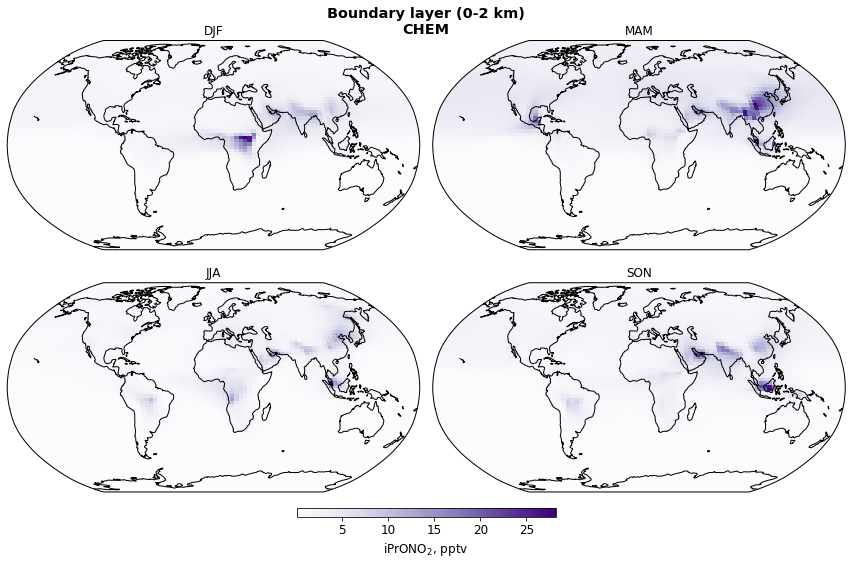

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p00 = ax[0,0].pcolormesh(cyclic_lons, lats, cyc_base_pbl_djf_mean.data, **pbl_mean_cf_kwargs)
ax[0,1].pcolormesh(cyclic_lons, lats, cyc_base_pbl_mam_mean.data, **pbl_mean_cf_kwargs)
ax[1,0].pcolormesh(cyclic_lons, lats, cyc_base_pbl_jja_mean.data, **pbl_mean_cf_kwargs)
ax[1,1].pcolormesh(cyclic_lons, lats, cyc_base_pbl_son_mean.data, **pbl_mean_cf_kwargs)
fig.subplots_adjust(hspace=-0.9, wspace=-0.5)
fig.tight_layout()
cax0 = fig.add_axes([0.35, 0.21, 0.3, 0.01])
fig.colorbar(p00, cax=cax0, orientation='horizontal', label=var_dict['str'][var]+', pptv')
fig.suptitle(f'Boundary layer (0-2 km)\n{base_exp}', y=0.8, weight='bold')
ax[0,0].set_title('DJF')
ax[0,1].set_title('MAM')
ax[1,0].set_title('JJA')
ax[1,1].set_title('SON')
for iax in ax.flatten(): 
    iax.set_global()
    iax.coastlines()
if savefig: fig.savefig(path_to_figs / f'{base_exp.lower()}_{var}_pbl_ssn_mean.png', bbox_inches='tight')

In [8]:
break

SyntaxError: 'break' outside loop (<ipython-input-8-6aaf1f276005>, line 4)

#### Free troposphere seasonal means

In [ ]:
# Extract time series of free troposphere (5-10 km) seasonal means
base_fre_djf = (base.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
base_fre_mam = (base.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
base_fre_jja = (base.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
base_fre_son = (base.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
# Calculate free troposphere seasonal mean differences
base_fre_djf_mean = base_fre_djf.collapsed('year', iris.analysis.MEAN)
base_fre_mam_mean = base_fre_mam.collapsed('year', iris.analysis.MEAN)
base_fre_jja_mean = base_fre_jja.collapsed('year', iris.analysis.MEAN)
base_fre_son_mean = base_fre_son.collapsed('year', iris.analysis.MEAN)
# Add cyclic point for plotting on a global map
cyc_base_fre_djf_mean, cyclic_lons = cartopy.util.add_cyclic_point(base_fre_djf_mean.data, coord=base_fre_djf_mean.coord('longitude').points)
cyc_base_fre_mam_mean = cartopy.util.add_cyclic_point(base_fre_mam_mean.data)
cyc_base_fre_jja_mean = cartopy.util.add_cyclic_point(base_fre_jja_mean.data)
cyc_base_fre_son_mean = cartopy.util.add_cyclic_point(base_fre_son_mean.data)
# Find max free troposphere seasonal mean
print(np.max(base_fre_djf_mean.data))
print(np.max(base_fre_mam_mean.data))
print(np.max(base_fre_jja_mean.data))
print(np.max(base_fre_son_mean.data))

In [ ]:
# Free troposphere seasonal mean difference plotting parameters
fre_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0,175,25))
fre_diff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r')
fre_pval_sc_kwargs = dict(transform=ccrs.PlateCarree(), s=10, c='k', marker='.', alpha=0.2)

In [ ]:
# Find min and max absolute free troposphere seasonal mean difference
print(min([np.min(cyc_fre_djf_diff.data), np.min(cyc_fre_mam_diff.data), np.min(cyc_fre_jja_diff.data), np.min(cyc_fre_son_diff.data)]))
print(max([np.max(cyc_fre_djf_diff.data), np.max(cyc_fre_mam_diff.data), np.max(cyc_fre_jja_diff.data), np.max(cyc_fre_son_diff.data)]))
# Find min and max % free troposphere seasonal mean difference
print(min([np.min(cyc_fre_djf_diff.data/cyc_base_fre_djf_mean.data*100), np.min(cyc_fre_mam_diff.data/cyc_base_fre_mam_mean.data*100), 
           np.min(cyc_fre_jja_diff.data/cyc_base_fre_jja_mean.data*100), np.min(cyc_fre_son_diff.data/cyc_base_fre_son_mean.data*100)]))
print(max([np.max(cyc_fre_djf_diff.data/cyc_base_fre_djf_mean.data*100), np.max(cyc_fre_mam_diff.data/cyc_base_fre_mam_mean.data*100), 
           np.max(cyc_fre_jja_diff.data/cyc_base_fre_jja_mean.data*100), np.max(cyc_fre_son_diff.data/cyc_base_fre_son_mean.data*100)]))

In [ ]:
# Additional plotting parameteres for free troposphere seasonal mean summary
fre_glb_absdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-12,14,2))
fre_glb_pctdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-14,16,2))#, extend='both')

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
ax[0,0].contourf(cyclic_lons, lats, cyc_base_fre_djf_mean.data, **fre_mean_cf_kwargs)
ax[0,1].contourf(cyclic_lons, lats, cyc_fre_djf_diff.data, **fre_glb_absdiff_cf_kwargs)
ax[0,2].contourf(cyclic_lons, lats, cyc_fre_djf_diff.data/cyc_base_fre_djf_mean.data*100, **fre_glb_pctdiff_cf_kwargs)

ax[1,0].contourf(cyclic_lons, lats, cyc_base_fre_mam_mean.data, **fre_mean_cf_kwargs)
ax[1,1].contourf(cyclic_lons, lats, cyc_fre_mam_diff.data, **fre_glb_absdiff_cf_kwargs)
ax[1,2].contourf(cyclic_lons, lats, cyc_fre_mam_diff.data/cyc_base_fre_mam_mean.data*100, **fre_glb_pctdiff_cf_kwargs)

ax[2,0].contourf(cyclic_lons, lats, cyc_base_fre_jja_mean.data, **fre_mean_cf_kwargs)
ax[2,1].contourf(cyclic_lons, lats, cyc_fre_jja_diff.data, **fre_glb_absdiff_cf_kwargs)
ax[2,2].contourf(cyclic_lons, lats, cyc_fre_jja_diff.data/cyc_base_fre_jja_mean.data*100, **fre_glb_pctdiff_cf_kwargs)

p30 = ax[3,0].contourf(cyclic_lons, lats, cyc_base_fre_son_mean.data, **fre_mean_cf_kwargs)
p31 = ax[3,1].contourf(cyclic_lons, lats, cyc_fre_son_diff.data, **fre_glb_absdiff_cf_kwargs)
p32 = ax[3,2].contourf(cyclic_lons, lats, cyc_fre_son_diff.data/cyc_base_fre_son_mean.data*100, **fre_glb_pctdiff_cf_kwargs)

fig.subplots_adjust(hspace=-0.8, wspace=-0.5)
fig.tight_layout()
cax0 = fig.add_axes([0.02, 0.12, 0.3, 0.01])
cax1 = fig.add_axes([0.35, 0.12, 0.3, 0.01])
cax2 = fig.add_axes([0.68, 0.12, 0.3, 0.01])
fig.colorbar(p30, cax=cax0, orientation='horizontal', label=f'{str_var}, ppbv')
fig.colorbar(p31, cax=cax1, orientation='horizontal', label=f'$\Delta${str_var}, ppbv')
fig.colorbar(p32, cax=cax2, orientation='horizontal', label=f'$\Delta${str_var}, %')
fig.text(0.02, 0.84, 'DJF')#, fontsize=12)
fig.text(0.02, 0.66, 'MAM')#, fontsize=12)
fig.text(0.02, 0.48, 'JJA')#, fontsize=12)
fig.text(0.02, 0.31, 'SON')#, fontsize=12)
fig.suptitle('Free troposphere (5-10 km)', y=0.9, weight='bold')
ax[0,0].set_title(f'{base_plt}')
ax[0,1].set_title(f'{sens_plt}-{base_plt}')
ax[0,2].set_title(f'{sens_plt}-{base_plt}')
for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_fre(fre_djf_diff, fre_djf_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_fre(fre_mam_diff, fre_mam_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_fre(fre_jja_diff, fre_jja_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_fre(fre_son_diff, fre_son_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax.flatten(): iax.set_global()
for iax in ax[:,0].flatten(): iax.coastlines(color='k')
for iax in ax[0:4,1:].flatten(): iax.coastlines(color='grey')
if savefig: fig.savefig(path_to_figs / f'{dir_var}_fre_seas_mean_all.png', bbox_inches='tight')